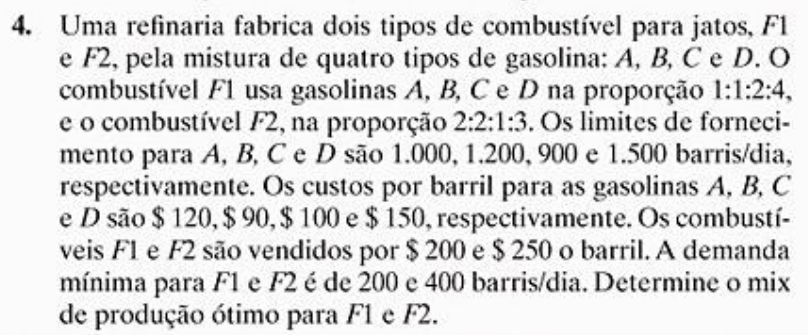

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Mix_Otimo_Combustivel_Jato')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Identificadores
combustiveis = ['F1', 'F2']
gasolinas = ['A', 'B', 'C', 'D']

# Dados financeiros
preco_venda_comb = {'F1': 200, 'F2': 250}
custo_gasolina = {'A': 120, 'B': 90, 'C': 100, 'D': 150}

# Limites de fornecimento (barris/dia)
limite_fornecimento_gas = {'A': 1000, 'B': 1200, 'C': 900, 'D': 1500}

# Demanda mínima (barris/dia)
demanda_min_comb = {'F1': 200, 'F2': 400}

# Composição dos combustíveis (em partes)
composicao_ratios = {
    'F1': {'A': 1, 'B': 1, 'C': 2, 'D': 4},
    'F2': {'A': 2, 'B': 2, 'C': 1, 'D': 3}
}

# Conversão da composição para percentual
total_partes = {c: sum(composicao_ratios[c].values()) for c in combustiveis}
composicao_perc = {
    c: {g: composicao_ratios[c][g] / total_partes[c] for g in gasolinas}
    for c in combustiveis
}

# Pré-cálculo do lucro líquido por barril de cada combustível
custo_combustivel = {
    c: sum(composicao_perc[c][g] * custo_gasolina[g] for g in gasolinas)
    for c in combustiveis
}
lucro_combustivel = {c: preco_venda_comb[c] - custo_combustivel[c] for c in combustiveis}
# Lucro F1 = 200 - 126.25 = 73.75
# Lucro F2 = 250 - 121.25 = 128.75

In [4]:
# 1. Variáveis de Decisão
# Quantidade (em barris) de cada combustível a ser produzida
barris_combustivel = model.continuous_var_dict(combustiveis, name='Barris')


# 2. Função Objetivo
# Maximizar o lucro total
expressao_lucro = (lucro_combustivel[c] * barris_combustivel[c] for c in combustiveis)
lucro_total = model.sum(expressao_lucro)
model.maximize(lucro_total)


# 3. Restrições

# Restrição 1: Disponibilidade de cada tipo de gasolina
# O total de cada gasolina usada nos combustíveis não pode exceder o fornecimento.
for g in gasolinas:
    expressao_uso_gas = (composicao_perc[c][g] * barris_combustivel[c] for c in combustiveis)
    soma_uso_gas = model.sum(expressao_uso_gas)
    restr_gas_logica = soma_uso_gas <= limite_fornecimento_gas[g]
    model.add_constraint(restr_gas_logica, ctname=f'limite_gas_{g}')

# Restrição 2: Demanda Mínima
# A produção de cada combustível deve atender à demanda mínima diária.
for c in combustiveis:
    restr_demanda_logica = barris_combustivel[c] >= demanda_min_comb[c]
    model.add_constraint(restr_demanda_logica, ctname=f'demanda_min_{c}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    lucro_maximo = model.objective_value
    print(f"Lucro Diário Máximo: ${lucro_maximo:,.2f}\n")

    print("--- Plano de Produção (barris/dia) ---")
    for c in combustiveis:
        prod_barris = barris_combustivel[c].solution_value
        print(f"  - Combustível {c}: {prod_barris:,.2f} barris")

    print("\n--- Consumo de Gasolina (barris/dia) ---")
    for g in gasolinas:
        consumo_gas = sum(composicao_perc[c][g] * barris_combustivel[c].solution_value for c in combustiveis)
        if consumo_gas > 1e-6:
            print(f"  - Gasolina {g}: {consumo_gas:,.2f} barris (de {limite_fornecimento_gas[g]} disponíveis)")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 3 rows and 0 columns.
Reduced LP has 3 rows, 2 columns, and 6 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =             0.000000

------ SOLUÇÃO ÓTIMA ------

Lucro Diário Máximo: $495,416.67

--- Plano de Produção (barris/dia) ---
  - Combustível F1: 200.00 barris
  - Combustível F2: 3,733.33 barris

--- Consumo de Gasolina (barris/dia) ---
  - Gasolina A: 958.33 barris (de 1000 disponíveis)
  - Gasolina B: 958.33 barris (de 1200 disponíveis)
  - Gasolina C: 516.67 barris (de 900 disponíveis)
  - Gasolina D: 1,500.00 barris (de 1500 disponíveis)
